In [512]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fancyimpute import KNN

In [15]:
ranking=pd.read_csv('dbRanking.csv',sep='|')
sunarp = pd.read_csv('dbSunarp.csv',sep='|')
sunat = pd.read_csv('dbSunat.csv',sep='|')
trans=pd.read_csv('dbTransacPyme_v2.csv',sep='|')
digital=pd.read_csv('dbAfilDigital.csv',sep='|')
rcc = pd.read_csv("dbRcc.csv", sep='|')
data = pd.read_csv('dbUniverso.csv',sep='|',low_memory=False)

In [486]:
trans=pd.read_csv('dbTransacPyme_v2.csv',sep='|')

# Universo

In [117]:
data.taxpayer_id=data.taxpayer_id.replace('914323    J','-1').astype('int64')
data.personal_id=data.personal_id.replace('914323    J','-1').astype('int64')
#data=data.drop(columns=['cutoff_date','segmento'])
data.personal_type=data.personal_type.replace(['L','R'],[0,1])
data.marital_status_type=data.marital_status_type.replace(['S','C','D','V','X','F','Y','U'],[0,1,2,3,4,5,6,7])
data.gender_type=data.gender_type.replace(['M','F'],[0,1])
data['age']=2020-data.birth_date
data=data.replace(np.nan,-1)

# Ranking

In [48]:
ranking=ranking[~ranking.company_size_desc.isnull()]
ranking.company_size_desc=ranking.company_size_desc.map({'PequeÃ±a empresa / Small-size Company':0,
                               'Mediana empresa / Medium-size Company':1,
                              'Gran Empresa / Big-size Company':2}).astype('int')
ranking=ranking[ranking.company_size_desc!=2]
ranking.activity_start_date=ranking.activity_start_date.replace('9999-12-31','2020-12-31')

ranking=ranking[~ranking.activity_start_date.isnull()]

ranking['activity_start_date']=ranking['activity_start_date'].astype("datetime64[ns]")
ranking['start_year']=pd.DatetimeIndex(ranking['activity_start_date']).year.astype('int')
ranking['start_month']=pd.DatetimeIndex(ranking['activity_start_date']).month.astype('int')

ranking.seniority_company_years_number=np.where(ranking.seniority_company_years_number.isnull(),
                                                2018-ranking.start_year,
                                                ranking.seniority_company_years_number).astype('int')
ranking.start_year=np.where(ranking.start_year==2020,
                            2018-ranking.seniority_company_years_number,ranking.start_year).astype('int')

ranking.foreign_company_mark_type=ranking.foreign_company_mark_type.replace(np.nan,0).replace('Extranjera',1)
ranking.private_public_mark_desc=ranking.private_public_mark_desc.replace('PRIVADA',0).replace('PUBLIC',1)
ranking.importer_mark_type=ranking.importer_mark_type.replace('IMPORTADORA',1).replace(np.nan,0).astype('int')
ranking.exporter_mark_type=ranking.exporter_mark_type.replace('EXPORTADORA',1).replace(np.nan,0).astype('int')

ranking=ranking.drop(columns=['ciiu_spanish_desc','spanish_sector_company_name','activity_start_date','cutoff_date'])
for i in ranking.loc[:,'ebitda_2014_amount':].columns:
    ranking[i]=ranking[i].replace(np.nan,0)
ranking.department_name=ranking.department_name.replace(np.nan,'Lima').replace('Av. JosÃ© GÃ¡lve','Lima')
ranking['flag_lima']=(ranking.province_name=='Lima').astype('int')

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
ranking.department_name=le.fit_transform(ranking.department_name).astype('int')
ranking.province_name=le.fit_transform(ranking.province_name).astype('int')
ranking.district_name=le.fit_transform(ranking.district_name).astype('int')

X_filled_knn = KNN(k=3).fit_transform(ranking)
filled=pd.DataFrame(X_filled_knn,columns=ranking.columns)

ranking=ranking.reset_index().drop(columns=['index'])
ranking['branches_number']=filled['branches_number'].astype('int')
ranking['employees_number']=filled['employees_number'].astype('int')
ranking['market_share_per']=filled['market_share_per']

ranking=ranking.drop(columns=['department_name','province_name','district_name','start_month'])

aggp={x:['mean'] for x in ranking.columns[2:]}
aggp['seniority_company_years_number']=['mean','max','min','std']
aggp['market_share_per']=['max','min','std']
aggp['start_year']=['max','min','std']
aggp['taxpayer_id']=['nunique']
ranking=ranking.groupby('company_economic_activity_id').agg(aggp).reset_index()
ranking.columns=[a+'_'+b for a,b in ranking.columns]
ranking=ranking.replace(np.nan,0)

C:\Users\Bucanero2010\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  object.__setattr__(self, name, value)


Imputing row 1/13179 with 0 missing, elapsed time: 481.318
Imputing row 101/13179 with 1 missing, elapsed time: 481.324
Imputing row 201/13179 with 1 missing, elapsed time: 481.330
Imputing row 301/13179 with 0 missing, elapsed time: 481.336
Imputing row 401/13179 with 0 missing, elapsed time: 481.339
Imputing row 501/13179 with 0 missing, elapsed time: 481.343
Imputing row 601/13179 with 0 missing, elapsed time: 481.347
Imputing row 701/13179 with 0 missing, elapsed time: 481.353
Imputing row 801/13179 with 0 missing, elapsed time: 481.358
Imputing row 901/13179 with 0 missing, elapsed time: 481.363
Imputing row 1001/13179 with 0 missing, elapsed time: 481.370
Imputing row 1101/13179 with 0 missing, elapsed time: 481.375
Imputing row 1201/13179 with 0 missing, elapsed time: 481.381
Imputing row 1301/13179 with 0 missing, elapsed time: 481.387
Imputing row 1401/13179 with 0 missing, elapsed time: 481.393
Imputing row 1501/13179 with 0 missing, elapsed time: 481.400
Imputing row 1601/13

# Sunat

In [27]:
no_nulos_sunat=sunat[~pd.isnull(sunat.personal_type)].reset_index().drop(['index'],axis=1)
nulos_sunat=sunat[pd.isnull(sunat.personal_type)].reset_index().drop(['index'],axis=1)
universo_sunat=data.drop_duplicates(subset=['taxpayer_id'], keep='first')
nulos_sunat_universo=nulos_sunat.merge(universo_sunat,left_on='taxpayer_id',right_on='taxpayer_id',how='left')
nulos_sunat_universo=nulos_sunat_universo.drop(['personal_type_x','personal_id_x',
       'taxpayer_start_date', 'taxpayer_end_date', 'comm_start_date',
       'company_economic_activity_id', 'cutoff_date_x','customer_id', 'sbs_customer_id', 'segmento',
       'gender_type', 'birth_date', 'marital_status_type', 'admission_date',
       'income_monthly_amount', 'cutoff_date_y'],axis=1)
sunat_parcial=pd.merge(nulos_sunat_universo,sunat.drop_duplicates(subset=['taxpayer_id'], keep='first'),left_on='taxpayer_id',right_on='taxpayer_id',how='left')
sunat_parcial=sunat_parcial.drop(['personal_type','personal_id'],axis=1) 
sunat_parcial=sunat_parcial.rename(columns={'personal_type_y':'personal_type',
                                   'personal_id_y':'personal_id'})
sunat_casifinal=pd.concat([no_nulos_sunat, sunat_parcial], axis=0)
sunat_casifinal['taxpayer_id']=sunat_casifinal['taxpayer_id'].astype('string')

no_nulos_sunat2=sunat_casifinal[~pd.isnull(sunat_casifinal.comm_start_date)].reset_index().drop(['index'],axis=1)
ranking_merge=ranking.drop_duplicates(subset=['taxpayer_id'], keep='first').reset_index().drop(['index'],axis=1)
ranking_merge['taxpayer_id']=ranking_merge['taxpayer_id'].astype('string')
nulos_sunat2=sunat_casifinal[pd.isnull(sunat_casifinal.comm_start_date)].reset_index().drop(['index'],axis=1)
nulos_sunat2['taxpayer_id']=nulos_sunat2['taxpayer_id'].astype('string')
nulos_sunat_ranking=pd.merge(ranking_merge[['taxpayer_id','activity_start_date']],nulos_sunat2,on='taxpayer_id',how='right')
nulos_sunat_ranking=nulos_sunat_ranking[['taxpayer_id', 'personal_type', 'personal_id', 'taxpayer_start_date',
       'taxpayer_end_date', 'activity_start_date', 'company_economic_activity_id',
       'cutoff_date']]
nulos_sunat_ranking=nulos_sunat_ranking.rename(columns={'activity_start_date':'comm_start_date'}) 
nulos_sunat_ranking=nulos_sunat_ranking.drop(['personal_type','personal_id',
       'taxpayer_start_date', 'taxpayer_end_date',
       'company_economic_activity_id', 'cutoff_date'],axis=1)
sunat_parcial2=pd.merge(nulos_sunat_ranking,sunat_casifinal.drop_duplicates(subset=['taxpayer_id'], keep='first'),left_on='taxpayer_id',right_on='taxpayer_id',how='left')
sunat_parcial2=sunat_parcial2.drop(['comm_start_date_y'],axis=1)
sunat_parcial2=sunat_parcial2.rename(columns={'comm_start_date_x':'comm_start_date'})
sunat_final=pd.concat([no_nulos_sunat2, sunat_parcial2], axis=0)

sunat_final['taxpayer_start_date']=pd.to_datetime(sunat_final['taxpayer_start_date'], format='%Y-%m-%d')
sunat_final['taxpayer_end_date']=sunat_final['taxpayer_end_date'].replace('9999-12-31','2100-12-31')
sunat_final['taxpayer_end_date']=pd.to_datetime(sunat_final['taxpayer_end_date'], format='%Y-%m-%d')
sunat_final['comm_start_date']=sunat_final['comm_start_date'].replace('9999-12-31','2100-12-31')
sunat_final['comm_start_date']=pd.to_datetime(sunat_final['comm_start_date'], format='%Y-%m-%d')

from datetime import datetime, timedelta
now = datetime.now()
sunat_final['diferencia_inicio_sunat']=(now-sunat_final['taxpayer_start_date']).astype("timedelta64[D]")
sunat_final['diferecia_fin_sunat']=(now-sunat_final['taxpayer_end_date']).astype("timedelta64[D]")
sunat_final['diferecia_end-start_sunat']=np.where(sunat_final['taxpayer_start_date']!='2100-12-31',(sunat_final['taxpayer_end_date']-sunat_final['taxpayer_start_date']).astype("timedelta64[D]"),0)
sunat_final['diferecia_start-iniciodeactividades_sunat']=(sunat_final['taxpayer_start_date']-sunat_final['comm_start_date']).astype("timedelta64[D]")
sunat_final['no_sigue_en_sunat'] = np.where(sunat_final['taxpayer_end_date']=='2100-12-31', 1, 0)
sunat_final['diferecia_fin_sunat']=np.where(sunat_final['diferecia_fin_sunat']<0,0,sunat_final['diferecia_fin_sunat'])
sunat_final['tenemos_inicio']=np.where(sunat_final['comm_start_date']!='2100-12-31',1,0)
sunat_final.company_economic_activity_id=sunat_final.company_economic_activity_id.replace('-',-1).astype('int64')
sunat_final.comm_start_date=np.where(sunat_final.comm_start_date.isnull(),sunat_final.taxpayer_start_date,sunat_final.comm_start_date)
sunat_final=sunat_final.replace(np.nan,0)
sunat_final=sunat_final.drop(columns=['personal_type','cutoff_date'])

# Sunarp

In [33]:
dict_resgistro = {'Cambio de Nombre/Denominación':'Cambio de Nombre','Inscripción de Vehóculo':'Inscripción de Vehículo',
                 'Posesión Desconocida':'Posesión Desconocida','Reemplacamiento':'Posesión Desconocida','S/D':'Posesión Desconocida',
                 'Transf x Cambio de Est.Civil':'Transferencia de Propiedad','Transferencia de Propiedad':'Transferencia de Propiedad'}
dict_vehiculo = {'AUTOMOVIL':'Auto','STAT.WAGON':'Auto','VEH.AUT.MEN.':'Moto','L3':'Moto','L5':'Moto',
                'CMTARURAL':'Camioneta','CMTAPICKUP':'Camioneta','CMTAPANEL':'Camioneta','M1':'Camioneta',
                'CAMION':'V-Grande','REMOLCADOR':'V-Grande','OMNIBUS':'V-Grande','SEMIREMOLQUE':'V-Grande','REMOLQUE':'V-Grande','N1':'V-Grande'}

sunarp.drop_duplicates(inplace=True)
sunarp = sunarp[~(sunarp['vehicle_class_type'].isnull())]
sunarp = sunarp[sunarp.vehicle_manufacture_year_id>1800]
sunarp.ownership_issued_date = sunarp.ownership_issued_date.str[:4]

registry_type = sunarp.ownership_registry_type.str.rsplit(' - ',n=1,expand=True)
sunarp['registry_type'] = registry_type[0].str.replace('�','ó',regex=True)
sunarp.registry_type = sunarp.registry_type.str.replace('Transferencia de Propiedad - Compra','Transferencia de Propiedad',regex=True)
sunarp.vehicle_class_type = sunarp.vehicle_class_type.str.replace(' ','',regex=True)
sunarp.transferred_number = sunarp.transferred_number.replace(np.nan,1)
sunarp.registry_type = sunarp.registry_type.replace(np.nan,'Posesión Desconocida')

sunarp.registry_type =sunarp.registry_type.map(dict_resgistro)
sunarp.vehicle_class_type = sunarp.vehicle_class_type.map(dict_vehiculo)

sunarp.drop(columns={'personal_type','cutoff_date','ownership_registry_type','vehicle_chassis_type'},inplace=True)
sunarp = sunarp.iloc[:,[0,5,2,1,3,4]]

sunarp_1 = sunarp[~(sunarp.ownership_issued_date.isnull())]
sunarp_2 = sunarp[sunarp.ownership_issued_date.isnull()]
sunarp_2.ownership_issued_date = sunarp_2.vehicle_manufacture_year_id
sunarp = pd.concat([sunarp_1,sunarp_2])
sunarp.ownership_issued_date = sunarp.ownership_issued_date.astype('float64')
sunarp['dif_time'] = sunarp['ownership_issued_date']-sunarp['vehicle_manufacture_year_id']

sunarp=sunarp.replace(['á','é','í','ó','ú','ñ'],['a','e','i','o','u','n'])
aggp={'ownership_issued_date':['max','mean'],'vehicle_manufacture_year_id':['max','min','mean'],
      'transferred_number':['sum'],'dif_time':['min','max','std']}
sunarp=sunarp.groupby(['personal_id','vehicle_class_type']).agg(aggp)
sunarp.columns=[a+'_'+b for a,b in sunarp.columns]
sunarp=sunarp.unstack().reset_index().fillna(0)
sunarp.columns=[a+'_'+b for a,b in sunarp.columns]

C:\Users\Bucanero2010\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  object.__setattr__(self, name, value)


# Digital

In [ ]:
digital=digital.replace('SI',1).replace('NO',0).replace('9999-12-31','2100-12-31')
digital['digital_date']=pd.DatetimeIndex(digital['digital_affiliation_date']).year.astype('int')*100+pd.DatetimeIndex(digital['digital_affiliation_date']).month.astype('int')
digital['online_banking_date']=pd.DatetimeIndex(digital['online_banking_affiliation_date']).year.astype('int')*100+pd.DatetimeIndex(digital['online_banking_affiliation_date']).month.astype('int')
digital['sms_date']=pd.DatetimeIndex(digital['sms_affiliation_date']).year.astype('int')*100+pd.DatetimeIndex(digital['sms_affiliation_date']).month.astype('int')
digital['sum_flags_digitales']=digital.online_banking_affiliation_type+digital.sms_affiliation_type+digital.digital_affiliation_type
digital=digital.drop(columns=['digital_affiliation_date','online_banking_affiliation_date','sms_affiliation_date','cutoff_date'])

# Transacciones

In [31]:
trans.COD_PERSONOR=trans.COD_PERSONOR.replace(np.nan,-1).astype('int64')
trans.COD_PERSONDE=trans.COD_PERSONDE.replace(np.nan,-1).astype('int64')

trans['HMS_OPER']=('000000'+trans.HMS_OPER.astype('str')).str[-6:]
trans['FEC_OPER']=trans['FEC_OPER'].astype("datetime64[ns]")
trans['hora_op']=trans.HMS_OPER.str[0:2].astype('int')
trans['minuto_op']=trans.HMS_OPER.str[2:4].astype('int')
trans['dia_op']=pd.DatetimeIndex(trans['FEC_OPER']).day.astype('int')
trans['mes_op']=pd.DatetimeIndex(trans['FEC_OPER']).month.astype('int')
trans['anio_op']=pd.DatetimeIndex(trans['FEC_OPER']).year.astype('int')
trans['mesanio_op']=trans.anio_op*100+trans.mes_op

aggp1={'COD_PERSONDE':['nunique'],'IMP_IMPOPER':['sum','median','mean','max','min','std'],'FEC_OPER':['nunique'],
      'IDW_CANAL':['nunique',lambda x:x.value_counts().index[0]],
       'COD_TRANSAC':['nunique',lambda x:x.value_counts().index[0]],'hora_op':['mean','median'],
     'HMS_OPER':['count'],'mesanio_op':['nunique','max','min']}
t_cliente=trans.groupby(['COD_PERSONOR']).agg(aggp1)

aggp2={'COD_PERSONOR':['nunique'],'IMP_IMPOPER':['sum','median','mean','max','min','std'],'FEC_OPER':['nunique'],
      'IDW_CANAL':['nunique',lambda x:x.value_counts().index[0]],
       'COD_TRANSAC':['nunique',lambda x:x.value_counts().index[0]],'hora_op':['mean','median'],
     'HMS_OPER':['count'],'mesanio_op':['nunique','max','min']}
t_vendedor=trans.groupby(['COD_PERSONDE']).agg(aggp2)

t_cliente.columns=['cli_'+a+'_'+b for a,b in t_cliente.columns]
t_vendedor.columns=['ven_'+a+'_'+b for a,b in t_vendedor.columns]

t_cliente['cli_ticket_promedio']=t_cliente.cli_IMP_IMPOPER_sum/t_cliente.cli_HMS_OPER_count
t_cliente['cli_monto_diario']=t_cliente.cli_IMP_IMPOPER_sum/t_cliente.cli_FEC_OPER_nunique
t_cliente['cli_monto_mensual']=t_cliente.cli_IMP_IMPOPER_sum/t_cliente.cli_mesanio_op_nunique
t_cliente['cli_trans_diarias']=t_cliente.cli_HMS_OPER_count/t_cliente.cli_FEC_OPER_nunique
t_cliente['cli_trans_mensual']=t_cliente.cli_HMS_OPER_count/t_cliente.cli_mesanio_op_nunique

t_vendedor['ven_ticket_promedio']=t_vendedor.ven_IMP_IMPOPER_sum/t_vendedor.ven_HMS_OPER_count
t_vendedor['ven_monto_diario']=t_vendedor.ven_IMP_IMPOPER_sum/t_vendedor.ven_FEC_OPER_nunique
t_vendedor['ven_monto_mensual']=t_vendedor.ven_IMP_IMPOPER_sum/t_vendedor.ven_mesanio_op_nunique
t_vendedor['ven_trans_diarias']=t_vendedor.ven_HMS_OPER_count/t_vendedor.ven_FEC_OPER_nunique
t_vendedor['ven_trans_mensual']=t_vendedor.ven_HMS_OPER_count/t_vendedor.ven_mesanio_op_nunique

enc_canal=trans.groupby('IDW_CANAL').IMP_IMPOPER.median().sort_values().reset_index()
enc_canal['ind']=range(1,len(enc_canal)+1)
enc_canal=enc_canal.drop(columns=['IMP_IMPOPER']).set_index('IDW_CANAL')['ind']
t_cliente['cli_IDW_CANAL_<lambda_0>']=t_cliente['cli_IDW_CANAL_<lambda_0>'].map(enc_canal)
t_vendedor['ven_IDW_CANAL_<lambda_0>']=t_vendedor['ven_IDW_CANAL_<lambda_0>'].map(enc_canal)

enc_codtransac=trans.groupby('COD_TRANSAC').IMP_IMPOPER.median().sort_values().reset_index()
enc_codtransac['ind']=range(1,len(enc_codtransac)+1)
enc_codtransac=enc_codtransac.drop(columns=['IMP_IMPOPER']).set_index('COD_TRANSAC')['ind']
t_cliente['cli_COD_TRANSAC_<lambda_0>']=t_cliente['cli_COD_TRANSAC_<lambda_0>'].map(enc_codtransac)
t_vendedor['ven_COD_TRANSAC_<lambda_0>']=t_vendedor['ven_COD_TRANSAC_<lambda_0>'].map(enc_codtransac)

t_cliente=t_cliente.reset_index()
t_vendedor=t_vendedor.reset_index()

# RFM

In [553]:
fechas=trans.groupby('COD_PERSONOR')['FEC_OPER'].max().astype("datetime64[ns]")
d=pd.Series(['2020-12-05']*len(fechas))
dias=(pd.DatetimeIndex(d)-fechas).dt.days.astype('int').reset_index()
RFM=t_cliente[['COD_PERSONOR','cli_ticket_promedio','cli_HMS_OPER_count']]
RFM=RFM.merge(dias,on=['COD_PERSONOR'])
RFM.columns=['codigo','Monetary value','Frequency','Recency']

In [554]:
recency_cleaned = RFM[RFM['Recency']<RFM['Recency'].quantile(0.99)]
frequency_cleaned = RFM[RFM['Frequency']<RFM['Frequency'].quantile(0.99)]
monetary_cleaned = RFM[RFM['Monetary value']<RFM['Monetary value'].quantile(0.99)]

rfm_table=pd.merge(pd.merge(recency_cleaned[['codigo','Recency','Frequency','Monetary value']],frequency_cleaned[['codigo']],on='codigo'),monetary_cleaned[['codigo']],on='codigo')

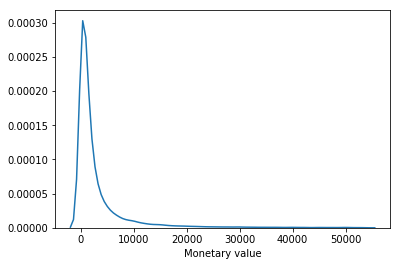

In [555]:
sns.distplot(rfm_table["Monetary value"],kde=True,hist=False)

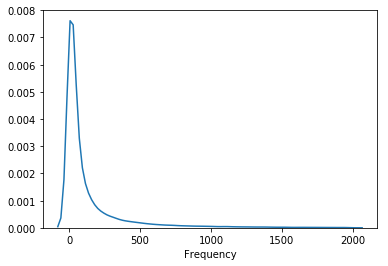

In [556]:
sns.distplot(rfm_table["Frequency"],kde=True,hist=False)

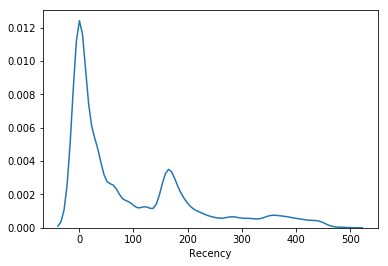

In [564]:
sns.distplot(rfm_table["Recency"],kde=True,hist=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

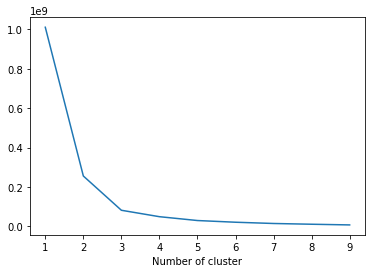

In [558]:

#Finding Optimum Clusters

sse={}
tx_recency = rfm_table[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### Function for ordering clusters
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_'+cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending = ascending).reset_index(drop=True)
    df_new['index']=df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
  
#Recency Clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_table[['Recency']])
rfm_table['RecencyCluster']=kmeans.predict(rfm_table[['Recency']])
rfm_table = order_cluster('RecencyCluster','Recency', rfm_table, False)

#Frequency Clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_table[['Frequency']])
rfm_table['FrequencyCluster']=kmeans.predict(rfm_table[['Frequency']])
rfm_table = order_cluster('FrequencyCluster','Frequency', rfm_table, True)

#Monetary Clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_table[['Monetary value']])
rfm_table['MonetaryCluster']=kmeans.predict(rfm_table[['Monetary value']])
rfm_table = order_cluster('MonetaryCluster','Monetary value', rfm_table, True)

# Define a function to map the values 
def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 
  
# Creating Recency Custer Tag Column
c=rfm_table.groupby('RecencyCluster')['Recency'].agg(['min','max','mean']).reset_index()
r1='<='+str(c.iloc[2,2]) 
r2=str(c.iloc[1,1])+' to '+str(c.iloc[1,2]) 
r3='>='+str(c.iloc[0,1])
# Create the dictionary 
R ={0 : r3, 1 : r2, 2 : r1} 
rfm_table['RecencyClusterTag']=rfm_table['RecencyCluster'].apply(set_value, args =(R, )) 

# Creating Frequency Custer Tag Column
a=rfm_table.groupby('FrequencyCluster')['Frequency'].agg(['min','max','mean']).reset_index()
f1='<='+str(a.iloc[0,2]) 
f2=str(a.iloc[1,1])+' to '+str(a.iloc[1,2]) 
f3='>='+str(a.iloc[2,1])
# Create the dictionary 
F ={0 : f1, 1 : f2, 2 :f3} 
rfm_table['FrequencyClusterTag']=rfm_table['FrequencyCluster'].apply(set_value, args =(F, )) 

# Creating Monetary Custer Tag Column
b=rfm_table.groupby('MonetaryCluster')['Monetary value'].agg(['min','max','mean']).reset_index()
m1='<='+str(int(round(b.iloc[0,2]))) 
m2=str(int(round(b.iloc[0,2])+1))+' to '+str(int(round(b.iloc[1,2]))) 
m3='>='+str(int(round(b.iloc[1,2])+1))
# Create the dictionary 
M ={0 : m1, 1 : m2, 2 :m3} 
rfm_table['MonetaryClusterTag']=rfm_table['MonetaryCluster'].apply(set_value, args =(M, )) 

rfm_table["FrequencyClusterTag"] = rfm_table["FrequencyClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[f1, f2, f3]))
rfm_table["MonetaryClusterTag"] = rfm_table["MonetaryClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[m1, m2,m3]))
rfm_table["RecencyClusterTag"] = rfm_table["RecencyClusterTag"].astype(pd.api.types.CategoricalDtype(categories=[r1, r2,r3]))

In [568]:
rfm_table['RecencyCOD']=rfm_table.RecencyClusterTag.replace(['<=95','121 to 267','>=274'],[0,1,2])
rfm_table['FrequencyCOD']=rfm_table.FrequencyClusterTag.replace(['<=240','241 to 824','>=826'],[0,1,2])
rfm_table['MonetaryCOD']=rfm_table.MonetaryClusterTag.replace(['<=6347','6348 to 22333','>=22334'],[0,1,2])
rfm_table['RFM_Score']=rfm_table['RecencyCOD']+rfm_table['FrequencyCOD']+rfm_table['MonetaryCOD']

In [576]:
import squarify

In [582]:
rfm_level_agg = rfm_table.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary value': ['mean', 'count']
}).round(1)
rfm_level_agg

Recency Frequency Monetary value       
             mean      mean           mean  count
RFM_Score                                        
0            24.6      67.5         1428.0  31117
1           108.8     138.1         2853.2  26530
2           225.0     258.6         5215.4  12541
3           218.9     240.3        19394.6   1638
4           306.7     179.5        33831.3    274
5           266.0     965.0        36105.7      1

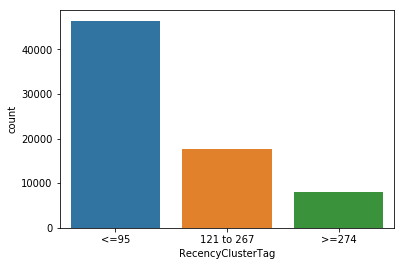

In [560]:
sns.countplot(x="RecencyClusterTag", data=rfm_table)

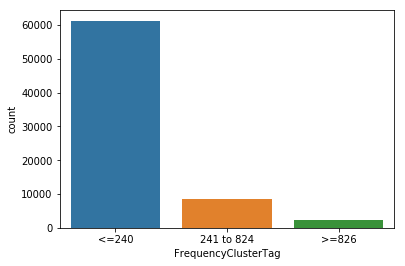

In [561]:
sns.countplot(x="FrequencyClusterTag", data=rfm_table)

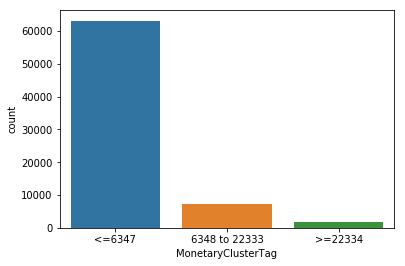

In [562]:
sns.countplot(x="MonetaryClusterTag", data=rfm_table)

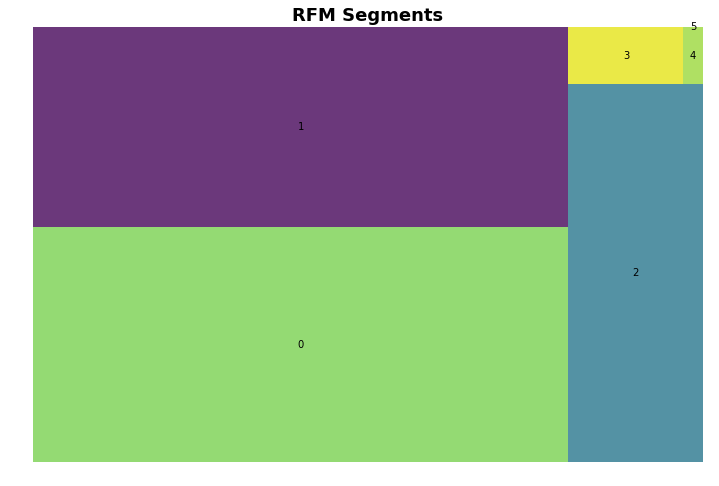

In [587]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(12, 8)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['0',
                     '1',
                     '2',
                     '3',
                     '4', 
                     '5'], alpha=0.8 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

# RCC y creacion de target

In [316]:
rcc.loc[(rcc['situacion_credito'] == 'VIGENTE'), 'target'] = 1
rcc.loc[(rcc['situacion_credito'] == 'VENCIDO'), 'target'] = 0
rcc.loc[(rcc['situacion_credito'] == 'JUDICIAL'), 'target'] = 0
rcc.loc[(rcc['situacion_credito'] == 'REFINANCIADO'), 'target'] = 0

q5=rcc.groupby(['sbs_customer_id','target'])['balance_amount'].count().unstack().add_prefix('countestado').reset_index().fillna(0)
q6=rcc.groupby(['sbs_customer_id','target'])['balance_amount'].mean().unstack().add_prefix('avg_deudaestado').reset_index().fillna(0)

train = q5.merge(q6, on='sbs_customer_id')

train_f=train.copy()
train=train.drop(columns=['sbs_customer_id'])

from sklearn.preprocessing import StandardScaler
columnas=train.columns
scaler = StandardScaler()
train=scaler.fit_transform(train)
train=pd.DataFrame(train,columns=columnas)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(train)
train['cluster']=kmeans.labels_

train_f['cluster']=train['cluster']

# Tabla final

In [70]:
full_sunat=sunat_final.merge(ranking,left_on='company_economic_activity_id',right_on='company_economic_activity_id_',how='left').replace(np.nan,0)
full_sunat.taxpayer_id=full_sunat.taxpayer_id.astype('int64')
full_data=data.merge(full_sunat,on=['taxpayer_id'],how='left').merge(sunarp,left_on=['personal_id_x'],right_on=['personal_id_'],how='left').merge(digital,left_on=['customer_id'],right_on=['customer_id'],how='left').merge(t_cliente,left_on=['customer_id'],right_on=['COD_PERSONOR'],how='left').merge(t_vendedor,left_on=['customer_id'],right_on=['COD_PERSONDE'],how='left').replace(np.nan,0)
full_data=full_data.drop(columns=['personal_id_y','admission_date'])

# Entrenamiento y prueba de modelos

In [389]:
training=full_data.merge(train_f[['sbs_customer_id','cluster']],on=['sbs_customer_id'])

In [391]:
training=training.drop(columns=['company_economic_activity_id','COD_PERSONDE','COD_PERSONOR'])

In [412]:
X=training.iloc[:,5:-1]
y=training.iloc[:,-1]

In [444]:
import sklearn.metrics as metrics
def optimize_cutoff(X,y,model,folds=5,escaler=5):
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=folds)

    test_scores=[]
    cutoffs=[]
    s_preds=[]
    s_test=[]    

    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        X2_train, y2_train = resamp(X_train,y_train,escaler)
        model.fit(X2_train,y2_train)
        p=model.predict_proba(X_test)
        probas=p[:,-1]
        fpr, tpr, threshold = metrics.roc_curve(y_test, probas)
        maximo=0
        t=0
        for i in threshold:
            preds=(probas>i).astype('int')
            s=f1_score(preds,y_test)
            if s>maximo:
                maximo=s
                t=i
        preds=(probas>t).astype('int')
        s_preds.append(sum(preds)/sum(y_test))
        test_scores.append(maximo)
        cutoffs.append(t)
        
    print('f1_score promedio: {}'.format(sum(test_scores)/folds))
    return sum(cutoffs)/folds

In [445]:
def resamp(X_train,y_train,escaler=5):
    df_temp=pd.concat([X_train,y_train],axis=1)
    from sklearn.utils import resample
    df_majority = df_temp[df_temp.cluster==1]
    df_minority = df_temp[df_temp.cluster==0]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=escaler*len(df_minority),    # to match majority class
                                     random_state=123)
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=int(len(df_majority)),     # to match minority class
                                     random_state=123)
    df_temp= pd.concat([df_majority_downsampled, df_minority_upsampled])
    Xtr,ytr = df_temp.iloc[:,:-1],df_temp.iloc[:,-1]
    return Xtr,ytr

In [413]:
from sklearn.preprocessing import StandardScaler
columnas=X.columns
scaler = StandardScaler()
X=scaler.fit_transform(X)
X=pd.DataFrame(X,columns=columnas)

In [394]:
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier,VotingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [452]:
model=lgb.LGBMClassifier(n_estimators=15)
model2=LogisticRegression(max_iter=1500,C=0.0001)
model3=ExtraTreesClassifier(n_estimators=100)

In [446]:
opt_cutoff=optimize_cutoff(X,y,model,5,3)

f1_score promedio: 0.9481333200388923


In [447]:
opt_cutoff=optimize_cutoff(X,y,model2,5,3)

f1_score promedio: 0.9477052728918357


In [453]:
opt_cutoff=optimize_cutoff(X,y,model3,5,3)

f1_score promedio: 0.9473667371634994


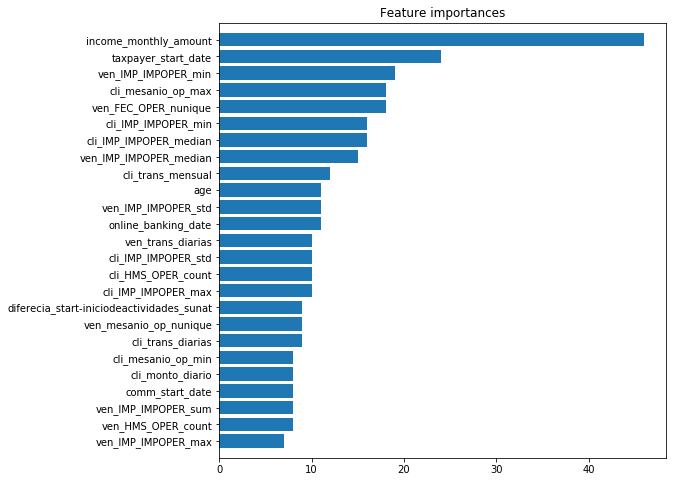

In [461]:
importances = model.feature_importances_
indices = np.argsort(importances)[-25:]

# Plot the feature importances of the forest
plt.figure(figsize = (8,8))
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices],align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(len(indices)), X[X.columns[indices]])#.columns[indices])
plt.ylim([-1, len(indices)])
plt.show()

In [460]:
model_final=model.fit(X,y)